In this notebook, we will try to build machine learning model that provides prediction for potential flight claims by delay/cancel.

In [2]:
# Import libraries
import pandas as pd, numpy as np, time
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [3]:
# Helper functions for the notebook
def get_metrics(to_check_y, to_check_pred):
    # We check the score of set result in two ways
    # Confusion matrix
    cm = confusion_matrix(to_check_y, to_check_pred)
    # Accuracy
    accuracy=accuracy_score(to_check_pred,to_check_y)
    
    return cm, accuracy

def print_metrics(to_check_y, to_check_pred):
    cm, accuracy = get_metrics(to_check_y, to_check_pred)
    
    print("Confusion matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Delay/Cancel case accuracy:", cm[1][1] / sum(cm[1]))

# Naive approach

For the most straightforward approach, only the per-record features are used for the prediction. 

The prediction is supposed to be a regression problem, as to predict expected monetary claim of all flights. Previous study shows that there are only two is_claim values, thus the model training would be treated as classification problem first (as to make accuracy measurement easier).

In [4]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data.csv')

# Check data columns
data_df.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim'],
      dtype='object')

We first modify the columns for model training:

In [5]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [6]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [7]:
# Check transformed result
data_df.sample(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,is_claim_bool
542398,1688047,329,50,1,143,26,14,0.4,2013-12-15,0,0
246104,765434,1840,29,1,1,73,3,-0.4,2015-07-20,0,0
802837,2493779,1977,45,1,93,90,1,0.2,2014-11-11,0,0
775268,2408432,1110,10,1,118,45,12,0.0,2014-03-06,0,0
141666,439287,1925,23,1,11,83,16,0.0,2015-06-05,0,0
594834,1850048,1751,9,1,11,69,19,0.2,2016-02-27,0,0
693077,2154064,113,28,1,41,9,11,0.2,2016-07-09,0,0
469014,1459032,702,40,1,118,28,16,0.9,2015-10-06,0,0
441509,1373337,1920,25,1,11,83,9,0.4,2016-06-18,0,0
681033,2116964,739,24,1,26,28,21,0.4,2016-06-10,0,0


In [8]:
# Get x/y columns
x_all = data_df[cat_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

There are several machine learning models that can tackle this problem. It is decided to use boosting (i.e. GBDT in particular) as it is relatively easier to tune for (in contrast to something like NN models that requires tuning network structure), and the underlying decision tree makes it easier to interpret for feature importance.

In [9]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMClassifier(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# Train model with catgeorical features
model_naive = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


The predicted is_claim_bool is then done by the model, and simply rounded as 0/1 for accuracy measurement.

In [10]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_naive.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[600414   1604]
 [ 20202   7159]]
Accuracy: 0.965353149691998
Delay/Cancel case accuracy: 0.2616497935016995


In [11]:
# Show Q1/Q2 error of classification-based model
# It is simply done by multiplying true negative/false positive result by claim amount
cm, _ = get_metrics(to_check_y, to_check_pred)

# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 27.71748024640161
Q2 error: 22173.984197121288


In [12]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_naive.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[256214   1469]
 [  9879   2173]]
Accuracy: 0.9579290785400486
Delay/Cancel case accuracy: 0.18030202456023897


In [13]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 33.65673716796115
Q2 error: 26925.389734368917


Although the model shows a 95% accuracy, the confusion matrix shows that there are many cases of actual needed-to-be-claimed flights, but mis-classified as normal flights. The classified ratio of delay/cancel flights in this case would be ~20%.

In [14]:
# Show feature importance of the approach
pd.DataFrame({'feature': cat_feats, 
              'Importance by split': model_naive.feature_importance(importance_type='split'), 
              'Importance by gain': model_naive.feature_importance(importance_type='gain')}).sort_values('Importance by gain', ascending=False)

,Importance by gain,Importance by split,feature
0,22343.027400,82665,flight_no
1,12597.248846,93331,Week
5,6690.270519,56092,std_hour
3,6185.199917,25679,Arrival
4,1402.889329,11933,Airline
2,0.000000,0,Departure


Train with regressor instead of classifier:

In [29]:
# Get x/y columns
x_all = data_df[cat_feats]
y_all = data_df['is_claim']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [30]:
lg = lgb.LGBMRegressor(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model_naive_regressor = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [31]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_naive_regressor.predict(to_check_train)

In [32]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 44.23232618822946
Q2 error: 16876.900381111376


In [35]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_naive_regressor.predict(to_check_train)

In [36]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 53.12546476009254
Q2 error: 23500.60364152895


# Feature engineering approach

In feature engineering approach, lagged statistics are added in different perspectives per different time bins. The model would suppose to make better decision from the extra features.

In [15]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data_transformed_new.csv')

# Check data size
data_df.columns

Index(['Unnamed: 0', 'flight_id', 'flight_no', 'Week', 'Departure', 'Arrival',
       'Airline', 'std_hour', 'delay_time', 'flight_date',
       ...
       'air_2_day_cancel_count', 'air_4_day_cancel_count',
       'air_wk_cancel_count', 'arr_air_hr_cancel_count',
       'arr_air_2_hr_cancel_count', 'arr_air_4_hr_cancel_count',
       'arr_air_day_cancel_count', 'arr_air_2_day_cancel_count',
       'arr_air_4_day_cancel_count', 'arr_air_wk_cancel_count'],
      dtype='object', length=139)

In [16]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
delay_time_and_count_feats = [col_str for col_str in list(data_df.columns) if col_str.endswith('_count') or col_str.endswith('_delay_time')]
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
all_feats = cat_feats + delay_time_and_count_feats
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [17]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [18]:
# Check transformed result
data_df.sample(10)

,Unnamed: 0,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,...,air_4_day_cancel_count,air_wk_cancel_count,arr_air_hr_cancel_count,arr_air_2_hr_cancel_count,arr_air_4_hr_cancel_count,arr_air_day_cancel_count,arr_air_2_day_cancel_count,arr_air_4_day_cancel_count,arr_air_wk_cancel_count,is_claim_bool
464489,464489,1445012,941,7,1,148,29,12,0.6,2015-02-13,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
202993,202993,629441,356,51,1,112,26,16,0.0,2013-12-23,...,3.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
824441,824441,2560987,1733,21,1,37,68,15,0.3,2016-05-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
592403,592403,1842734,2309,11,1,129,113,13,-0.1,2014-03-16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
47589,47589,147406,96,18,1,59,9,16,0.2,2014-05-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
128662,128662,399188,718,11,1,118,28,12,0.5,2016-03-12,...,15.0,45.0,0.0,0.0,0.0,1.0,1.0,3.0,12.0,0
417968,417968,1299981,900,39,1,21,28,20,0.5,2015-09-28,...,16.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
229396,229396,712700,190,3,1,81,15,21,1.1,2016-01-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
798144,798144,2479207,1626,39,1,117,56,2,-0.1,2013-09-25,...,9.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
37208,37208,115405,1369,31,1,106,50,16,0.3,2015-08-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
# Get x/y columns
x_all = data_df[all_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [20]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMClassifier(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 3000,
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    "n_estimators": 300
}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Accuracy measurement from feature engineering approach:

In [21]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[602016      2]
 [  1233  26128]]
Accuracy: 0.9980377483201696
Delay/Cancel case accuracy: 0.9549358576075436


In [22]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 1.5698013438643488
Q2 error: 1255.841075091479


In [23]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = abs(model.predict(to_check_train).round())
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[256731    952]
 [  6935   5117]]
Accuracy: 0.9707601905573989
Delay/Cancel case accuracy: 0.42457683372054433


In [24]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 23.391847554080858
Q2 error: 18713.478043264684


The result shows that the model fits well on the training set. However, testing set shows quite a drop in accuracy, especially upon delay/cancel case. Nonetheless, the model now achieves ~42% accuracy on delay/cancel case as opposed to ~20% in the naive approach.

The feature importance is as below:

In [25]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by split', ascending=False)

,Importance by gain,Importance by split,feature
0,22785.741544,22286,flight_no
1,8265.696842,19065,Week
6,4182.018760,8252,dep_hr_delay_time
16,2368.475337,7988,arr_day_delay_time
30,2882.547090,7807,arr_air_day_delay_time
7,2320.582396,7127,dep_2_hr_delay_time
15,2645.768800,6954,arr_4_hr_delay_time
22,2106.379612,6840,air_4_hr_delay_time
8,2623.867868,6465,dep_4_hr_delay_time
21,1923.715081,6346,air_2_hr_delay_time


In [72]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by gain', ascending=False)

,Importance by gain,Importance by split,feature
0,22785.741544,22286,flight_no
1,8265.696842,19065,Week
89,5402.275617,1989,arr_air_wk_cancel_count
14,4684.201030,5918,arr_2_hr_delay_time
31,4265.747433,5951,arr_air_2_day_delay_time
6,4182.018760,8252,dep_hr_delay_time
32,3355.048912,5072,arr_air_4_day_delay_time
13,3162.707821,5296,arr_hr_delay_time
30,2882.547090,7807,arr_air_day_delay_time
15,2645.768800,6954,arr_4_hr_delay_time


In [73]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by split', ascending=False)

{'Importance by gain': {0: 22785.741543677635,
  1: 8265.696841794997,
  2: 0.0,
  3: 2566.4979686550796,
  4: 324.4233811860904,
  5: 2465.294217339717,
  6: 4182.018759556115,
  7: 2320.582395770587,
  8: 2623.8678677324206,
  9: 1506.6443330906332,
  10: 1082.5602179262787,
  11: 931.1423593442887,
  12: 793.4997778441757,
  13: 3162.7078207060695,
  14: 4684.201029602438,
  15: 2645.768799847923,
  16: 2368.4753367686644,
  17: 1741.056628643535,
  18: 1333.3901754803956,
  19: 1453.1553288036957,
  20: 1801.1771837351844,
  21: 1923.7150809401646,
  22: 2106.3796119904146,
  23: 1517.329224052839,
  24: 1126.4509760495275,
  25: 1046.1169102424756,
  26: 1032.0695311846212,
  27: 842.5324221206829,
  28: 1124.2009921483696,
  29: 1459.7750114304945,
  30: 2882.5470897015184,
  31: 4265.747432528064,
  32: 3355.0489123621956,
  33: 2520.827833048068,
  34: 1161.485850716941,
  35: 661.3234527427703,
  36: 779.9275167994201,
  37: 1103.5084741245955,
  38: 1031.1120948949829,
  39: 

Train with regressor instead of classifier:

In [43]:
# Get x/y columns
x_all = data_df[all_feats]
y_all = data_df['is_claim']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [44]:
lg = lgb.LGBMRegressor(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model_feat_eng_regressor = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [ ]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_feat_eng_regressor.predict(to_check_train)

In [ ]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

In [ ]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_feat_eng_regressor.predict(to_check_train)

In [ ]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

## Further inspection on model performance

In [74]:
# Use raw values in below inspection
to_check_pred_raw = model.predict(to_check_train)

<Figure size 432x288 with 0 Axes>

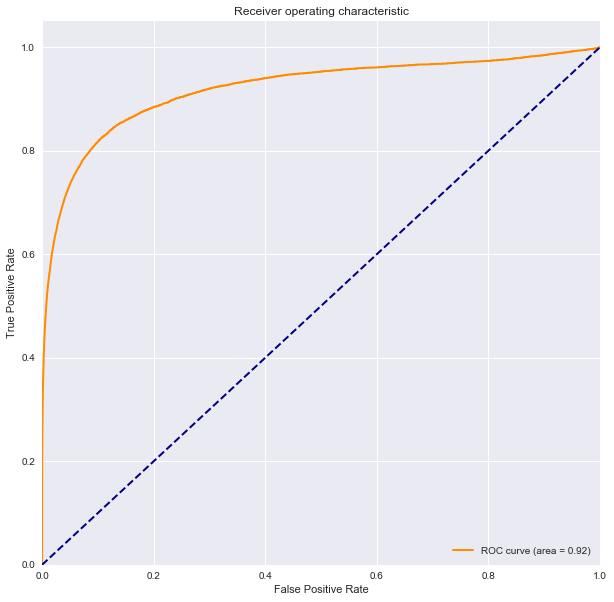

In [75]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(to_check_y, to_check_pred_raw)
roc_auc = auc(fpr,tpr)
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Although the ROC graph shows an AUC of 0.91, that should bear in mind that the given dataset is highly skewed to positive labels (i.e. flight is not claimed). The "residual" appearance of flight claim case is insignificant from this graph.

Plotting the prediction distribution of the two labels (is_claim_bool = 0/1) shows a better truth in this case:

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

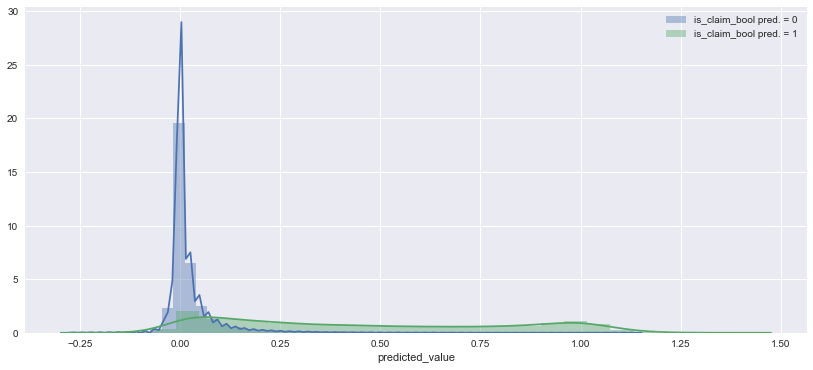

In [76]:
prob_df = pd.DataFrame({'predicted_value': to_check_pred_raw, 'true_value': to_check_y})
plt.figure()
plt.figure(figsize=(14,6))
sns.distplot(prob_df[prob_df['true_value'] == 0]['predicted_value'], label='is_claim_bool pred. = 0')
sns.distplot(prob_df[prob_df['true_value'] == 1]['predicted_value'], label='is_claim_bool pred. = 1')
plt.legend()

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

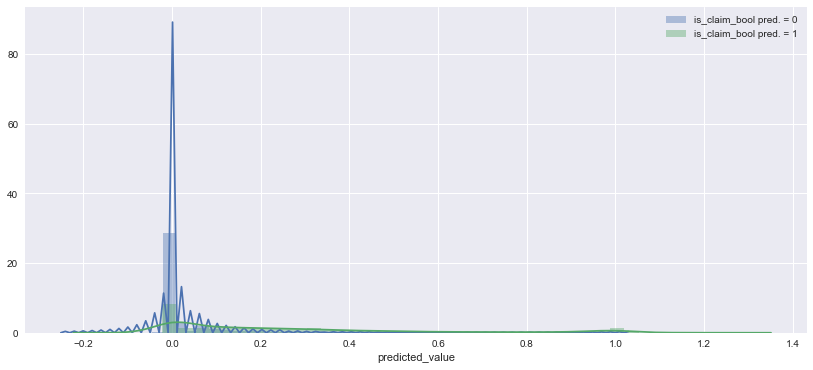

In [77]:
# Compare with naive approach 
to_check_pred_raw = model_naive.predict(to_check_train)
prob_df = pd.DataFrame({'predicted_value': to_check_pred_raw, 'true_value': to_check_y})
plt.figure()
plt.figure(figsize=(14,6))
sns.distplot(prob_df[prob_df['true_value'] == 0]['predicted_value'], label='is_claim_bool pred. = 0')
sns.distplot(prob_df[prob_df['true_value'] == 1]['predicted_value'], label='is_claim_bool pred. = 1')
plt.legend()

It is shown that the model is good at predicting is_claim_bool = 0 case, whereas is_claim_bool = 1 case would be hard, as the predicted value spreaded across [0, 1]. But from the graph, we can find a tradeoff between true-negative and false-positive by selecting a optimal threshold for predicting is_claim_bool as 1 (previously we just rounded off the prediction value).

In [34]:
# Attempt to select appropriate cutoff for prob
# Record false positive and true negative rates
fpr = []
tnr = []

for i in range(20):
    ratio = i / 20

    # custom function
    def pred_by_cutoff(x):
        return 1 if x > ratio else 0

    # define vectorized sigmoid
    pred_by_cutoff_v = np.vectorize(pred_by_cutoff)

    # test
    cm, _ = print_metrics(to_check_y, pred_by_cutoff_v(to_check_pred_raw))
    fp = cm[1][0]
    tn = cm[0][1]
    print("Normal flight accuracy:", cm[0][0] / sum(cm[0]))
    print("Ratio:", ratio, "Wrong:", fp+tn)
    fpr.append(fp)
    tnr.append(tn)

[[ 97710 159973]
 [   562  11490]]
Accuracy: 0.4048417891634382
Delay/Cancel case accuracy: 0.9533687354795884
Normal flight accuracy: 0.37918683033028955
Ratio: 0.0 Wrong: 160535
[[218466  39217]
 [  1758  10294]]
Accuracy: 0.8480916455039205
Delay/Cancel case accuracy: 0.8541320942582145
Normal flight accuracy: 0.847809129822301
Ratio: 0.05 Wrong: 40975
[[238341  19342]
 [  2659   9393]]
Accuracy: 0.9184347600422637
Delay/Cancel case accuracy: 0.7793727182210421
Normal flight accuracy: 0.9249387813709092
Ratio: 0.1 Wrong: 22001
[[246188  11495]
 [  3423   8629]]
Accuracy: 0.9446938662020131
Delay/Cancel case accuracy: 0.7159807500829738
Normal flight accuracy: 0.9553909260603144
Ratio: 0.15 Wrong: 14918
[[250279   7404]
 [  4074   7978]]
Accuracy: 0.9574471240291397
Delay/Cancel case accuracy: 0.661964819117159
Normal flight accuracy: 0.971267021883477
Ratio: 0.2 Wrong: 11478
[[252663   5020]
 [  4678   7374]]
Accuracy: 0.9640461934861995
Delay/Cancel case accuracy: 0.611848655824759

<Figure size 432x288 with 0 Axes>

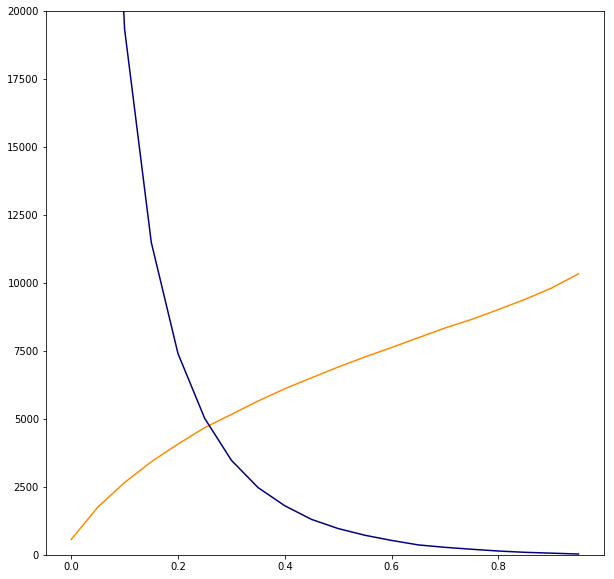

In [35]:
prob_bins = [i / 20 for i in range(20)]
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(prob_bins, fpr, color='darkorange')
plt.plot(prob_bins, tnr, color='navy')
plt.ylim([0, 20000])
plt.show()

In [25]:
np.histogram(to_check_pred_raw, bins=np.arange(0,1,0.1))

(array([137190,    284,    276,    319,    334,    336,    313,    359,
           463], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

At the end, the problem is treated again as regression problem.

In [158]:
# Get x/y columns
x_all = data_df
y_all = data_df['is_claim']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)
train = train[all_feats]
test = test[all_feats]

In [159]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMRegressor(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [160]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()

In [161]:
# Q1 error
sum(abs(to_check_pred - to_check_y)) / len(to_check_y)

19.05464751763246

In [162]:
# Q2 error
sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y)

2536.8779749562664

In [163]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = abs(model.predict(to_check_train).round())

In [164]:
# Q1 error
sum(abs(to_check_pred - to_check_y)) / len(to_check_y)

44.96248910968173

In [165]:
# Q2 error
sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y)

15491.212349157506

In [ ]:
# Try again with 10-fold
for i in range(10):
    train, test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3)
    
    lg = lgb.LGBMClassifier(silent=False)
    d_train = lgb.Dataset(train, label=y_train)
    params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}
    model = lgb.train(params, d_train, categorical_feature = cat_feats)
    
    print("Round ", i, "---------------------")
    # Testing set metrics
    to_check_train, to_check_y = test, y_test
    to_check_pred = model.predict(to_check_train).round()
    print_metrics(to_check_y, to_check_pred)